### Cohort Analysis

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt


In [11]:
!curl https://dl.dropboxusercontent.com/u/16006464/client_secret.json -o client_secret.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2335  100  2335    0     0   6591      0 --:--:-- --:--:-- --:--:--  6596


In [12]:
# Connect to the BigQuery API
from googleapiclient.discovery import build
from oauth2client import client
credentials = client._get_application_default_credential_from_file('client_secret.json')
credentials = credentials.create_scoped('https://www.googleapis.com/auth/bigquery')
bigquery_service = build('bigquery', 'v2', credentials=credentials)

In [17]:
# Run a SQL query
#
# The first subquery S computes the total amount of rewards posted by a requester
# which we then aggregate by month.
# The second subquery C computes the cohort of the requester; we define as cohort_id
# the month in which we have first seen a requester in our data.
#
# The string manipulation is just to get the dates
# represented as YYYY-MM
# 
# For efficiency, we store the results in a BigQuery table first, retrieve on Python directly
# from the materialized table.
'''
SELECT
  SUM(S.reward) AS reward, S.year_month AS year_month, S.requesterId AS requesterId, C.cohort AS cohort
FROM (
  SELECT
    -I.rewardDiff/100 AS reward,
    STRING(YEAR(I.timestamp)) + '-' + RIGHT('0' + STRING(MONTH(I.timestamp)), 2) AS year_month,
    G.requesterId AS requesterId
  FROM
    entities.HITinstance I
  INNER JOIN
    entities.HITgroup G
  ON
    G.groupId=I.groupId
  WHERE
    I.rewardDiff<0 AND I.rewardDiff>-1000000) S
INNER JOIN (
  SELECT
    requesterId,
    STRING(YEAR(MIN(firstSeen))) + '-' + RIGHT('0' + STRING(MONTH(MIN(firstSeen))), 2) AS cohort
  FROM
    entities.HITgroup
  GROUP BY
    requesterId) C
ON
  S. requesterId = C.requesterId
GROUP BY
  requesterId, year_month, cohort
ORDER BY
  requesterId, year_month
'''


query_request = bigquery_service.jobs()
query_data = {
    'query': (
        '''
SELECT * FROM entities.m_cohort_rewards_per_month
WHERE year_month!='2016-03' AND cohort!='2014-05'
ORDER BY cohort, requesterId, year_month
        ''')
}

query_response = query_request.query(
            projectId='crowd-power',
            body=query_data).execute()

In [18]:
# Put the SQL results in a Pandas Dataframe
import pandas as pd
import numpy as np
columns = [f.get('name') for f in query_response['schema']['fields']]
rows = [tuple([row['f'][i]['v'] for i in range(len(row['f']))]) for row in query_response['rows']]
df = pd.DataFrame(data=rows, columns=columns, dtype=float)
df.to_csv("cohort-analysis-rewards.csv")
df

,reward,year_month,requesterId,cohort
0,2.00,2014-06,A03162451W4B78HL2UOQF,2014-06
1,10.00,2014-06,A0589310131IJVORERSA2,2014-06
2,2.00,2014-09,A0589310131IJVORERSA2,2014-06
3,22.00,2014-11,A0589310131IJVORERSA2,2014-06
4,14.00,2014-12,A0589310131IJVORERSA2,2014-06
5,4.00,2014-06,A1008264H2SQB9,2014-06
6,2.40,2014-06,A1028WCOHNB54U,2014-06
7,1.20,2014-07,A1028WCOHNB54U,2014-06
8,12.00,2014-06,A102CP8ZOF222J,2014-06
9,17.00,2014-07,A102CP8ZOF222J,2014-06


In [23]:
# Transform the dataframe into a table with cohorts as rows and year_month of activity columns. Each cell contains the 
# sum of 
pivot = pd.pivot_table(df, 
                       values='requesterId', 
                       index=['year_month'], 
                       columns=['cohort'], 
                       aggfunc=lambda x: len(x.unique()))
pivot

cohort,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,...,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02
year_month,,,,,,,,,,,,,,,,,,,,,
2014-06,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07,533,1436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,286,470,1244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,231,232,336,1035,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,206,173,165,304,1155,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11,179,133,129,145,375,1267,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12,143,129,98,102,139,333,812,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01,151,124,91,97,95,147,204,934,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02,169,146,118,126,120,131,131,324,1495,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


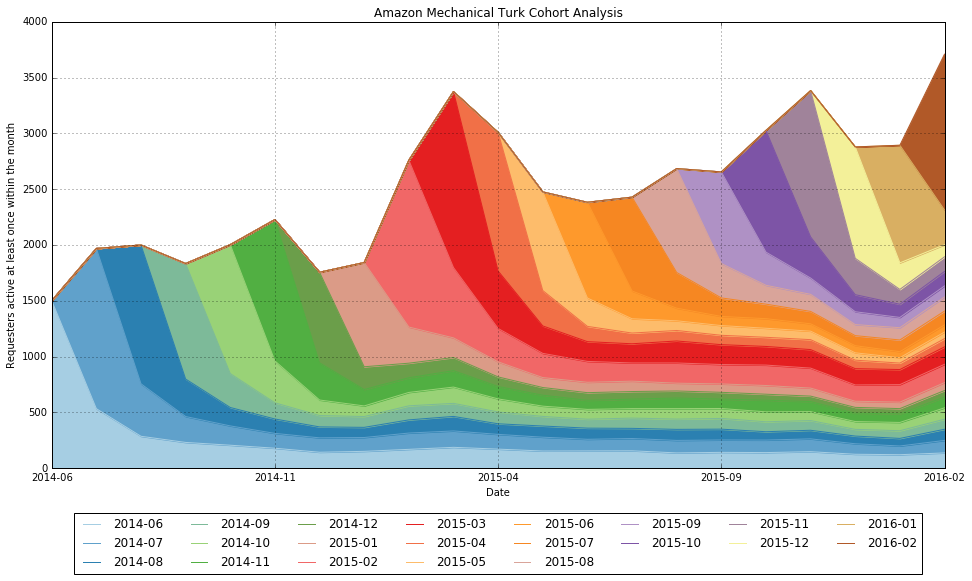

In [24]:
f = plt.figure(edgecolor='k')
ax=f.gca()
pivot.plot(kind='area', stacked=True, legend=True, figsize=(16,8), cmap='Paired', grid=True, ax=ax);

plt.title('Amazon Mechanical Turk Cohort Analysis', color='black')
plt.legend(loc='lower center', ncol=8, bbox_to_anchor=[0.5, -0.25])
ax.set_ylabel("Requesters active at least once within the month")
ax.set_xlabel("Date")
plt.show()

f.savefig('mturk-cohort-analysis.png', bbox_inches='tight')

In [8]:
# Transform the dataframe into a table with cohorts as rows and year_month of activity columns. Each cell contains the 
# sum of 
pivot = pd.pivot_table(df, values='reward', index=['year_month'], columns=['cohort'], aggfunc=np.sum)
pivot

cohort,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,...,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02
year_month,,,,,,,,,,,,,,,,,,,,,
2014-06,245562.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07,93817.18,118136.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,101365.36,70999.66,126308.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,36831.62,57714.93,75105.44,66197.49,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,38980.83,31047.84,22921.59,42535.59,197171.67,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11,29737.17,36578.06,21530.37,26140.86,151574.97,90403.01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12,15937.99,18217.43,24333.15,15106.61,60582.30,70788.86,152449.91,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01,19078.97,16870.80,21432.45,16816.66,37273.98,48440.97,163038.69,52638.19,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02,25669.87,21486.24,30489.42,12618.54,35542.95,35686.31,38538.77,37399.22,89036.72,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


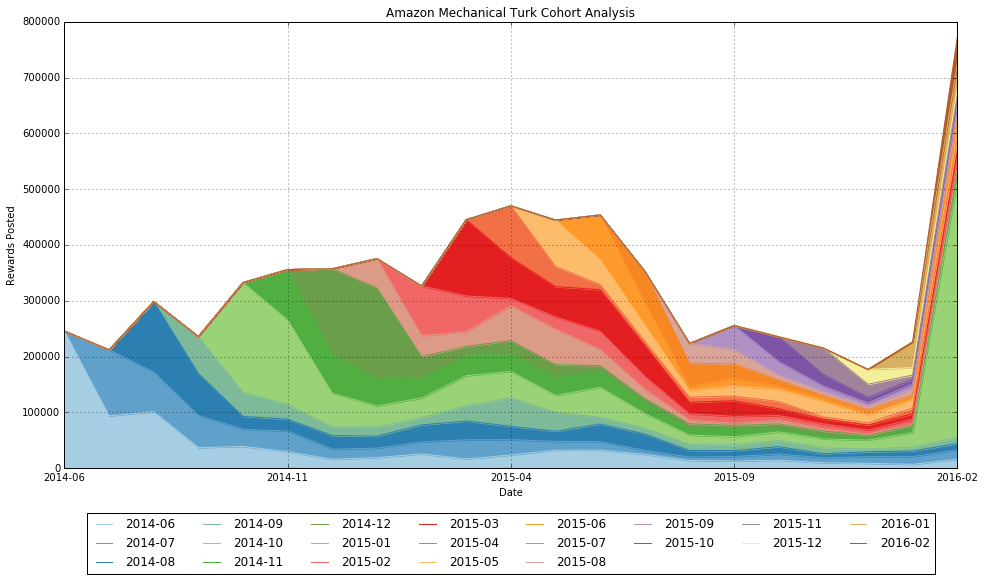

In [9]:
f = plt.figure(edgecolor='k')
ax=f.gca()
pivot.plot(kind='area', stacked=True, legend=True, figsize=(16,8), cmap='Paired', grid=True, ax=ax);

plt.title('Amazon Mechanical Turk Cohort Analysis', color='black')
plt.legend(loc='lower center', ncol=8, bbox_to_anchor=[0.5, -0.25])
ax.set_ylabel("Rewards Posted")
ax.set_xlabel("Date")
plt.show()

f.savefig('mturk-cohort-analysis.png', bbox_inches='tight')